<a href="https://www.kaggle.com/code/javihm77/catboost-baseline-chapu-optuna?scriptVersionId=134070465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
import pickle
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 43.4 s, sys: 18.9 s, total: 1min 2s
Wall time: 57.8 s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32
20090312431273200,512,836732,"""navigate_click…","""undefined""",13,null,290.153564,-204.499359,null,null,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",0
20090312431273200,513,837245,"""navigate_click…","""undefined""",13,null,353.805603,-210.332062,21.0,0.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",513
20090312431273200,514,837779,"""navigate_click…","""undefined""",13,null,587.680054,-280.706238,108.0,44.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",534
20090312431273200,515,838446,"""navigate_click…","""undefined""",13,null,751.496887,-102.15329,43.0,124.0,null,null,"""toentry""","""tunic.capitol_…","""text_fqid_None…","""13-22""",667
20090312431273200,516,839629,"""map_hover""","""basic""",13,null,null,null,null,null,67.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1183
20090312431273200,517,840662,"""map_hover""","""basic""",13,null,null,null,null,null,983.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1033
20090312431273200,518,840780,"""map_hover""","""basic""",13,null,null,null,null,null,100.0,null,"""tunic.historic…","""tunic.capitol_…","""text_fqid_None…","""13-22""",118
20090312431273200,519,840830,"""map_hover""","""basic""",13,null,null,null,null,null,35.0,null,"""tunic.capitol_…","""tunic.capitol_…","""text_fqid_None…","""13-22""",50


In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 11.4 s, sys: 840 ms, total: 12.2 s
Wall time: 6.43 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 29.8 s, sys: 1.11 s, total: 30.9 s
Wall time: 16.4 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 48.8 s, sys: 1.39 s, total: 50.2 s
Wall time: 26.3 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.7].index)
drop2 = list(null2[null2 > 0.7].index)
drop3 = list(null3[null3 > 0.7].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1225 1040 890


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 487 787 1042 features
We will train with 23562 users info


# Optuna Parameters optimization

In [27]:
def objective(trial,X,y):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    cat_params = {
        "depth": trial.suggest_int("depth", 1, 9),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'n_estimators': trial.suggest_int('n_estimators', 150, 750),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'random_seed': 42,
        'verbose': False,
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "used_ram_limit": "6gb",
        'eval_metric': 'AUC'
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**cat_params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=80)

    preds = gbm.predict(valid_x)
    pred_labels = (preds > 0.63).astype('int')

    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [28]:
# %%time

rf_best_params = []
studies = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in tqdm(range(1,19)): #1-19
        
    if t <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("")    
    print("#"*25)
    print(f'question{t}, with{len(FEATURES)}features')
    print('#'*25)
            
    # TRAIN DATA
    train_x = df[FEATURES]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_x, train_y['correct'])
    
    #Optuna 
    study = optuna.create_study(study_name=f"catboost_{t}",direction="maximize")
    study.optimize(func, n_trials=10, timeout=500)
    
    print(f'*** Model: {grp}_{t}')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('Best value:', study.best_value)
    
    rf_best_params.append(study.best_trial.params)
    studies.append(study)
        
print("-"*80)


  0%|          | 0/18 [00:00<?, ?it/s]


#########################
question1, with487features
#########################


[I 2023-06-19 04:00:17,925] A new study created in memory with name: catboost_1
[I 2023-06-19 04:00:21,385] Trial 0 finished with value: 0.7305135096901967 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 419, 'learning_rate': 0.0001720847666481078, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.11534440487541554, 'min_data_in_leaf': 66, 'subsample': 0.4132728822109314}. Best is trial 0 with value: 0.7305135096901967.
[I 2023-06-19 04:00:38,851] Trial 1 finished with value: 0.7484792757108502 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 634, 'learning_rate': 0.26198492222919445, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.4509039677378685, 'min_data_in_leaf': 71, 'bagging_temperature': 2.4496035744747036}. Best is trial 1 with value: 0.7484792757108502.
[I 2023-06-19 04:01:10,407] Trial 2 finished with value: 0.7248550007073136 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 481, 'learning_

*** Model: 0-4_1
Number of finished trials: 10
Best trial: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 502, 'learning_rate': 0.26676414668054726, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5983150847028335, 'min_data_in_leaf': 31, 'bagging_temperature': 5.463025539330612}
Best value: 0.751732918376008

#########################
question2, with487features
#########################


[I 2023-06-19 04:06:25,927] Trial 0 finished with value: 0.9782147404159004 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 501, 'learning_rate': 0.06866374805536632, 'objective': 'Logloss', 'colsample_bylevel': 0.5520794275339499, 'min_data_in_leaf': 96, 'subsample': 0.3622478401590242}. Best is trial 0 with value: 0.9782147404159004.
[I 2023-06-19 04:07:08,915] Trial 1 finished with value: 0.9786391285896167 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 607, 'learning_rate': 0.00018973409290260517, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6622311699922226, 'min_data_in_leaf': 74, 'bagging_temperature': 3.0909500382527377}. Best is trial 1 with value: 0.9786391285896167.
[I 2023-06-19 04:07:21,823] Trial 2 finished with value: 0.9784976658650446 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 445, 'learning_rate': 0.10927346921093552, 'objective': 'Logloss', 'colsample_bylevel': 0.601892603

*** Model: 0-4_2
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 721, 'learning_rate': 0.03122125687202411, 'objective': 'Logloss', 'colsample_bylevel': 0.6194953893348251, 'min_data_in_leaf': 97, 'subsample': 0.1039016768133974}
Best value: 0.9806196067336257

#########################
question3, with487features
#########################


[I 2023-06-19 04:13:49,211] Trial 0 finished with value: 0.9352100721459895 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 252, 'learning_rate': 0.00012144874263818195, 'objective': 'Logloss', 'colsample_bylevel': 0.18833063813463286, 'min_data_in_leaf': 59, 'subsample': 0.7818553329063334}. Best is trial 0 with value: 0.9352100721459895.
[I 2023-06-19 04:14:25,387] Trial 1 finished with value: 0.9373320130145707 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 516, 'learning_rate': 0.0001578136620277839, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.3824749921638138, 'min_data_in_leaf': 47}. Best is trial 1 with value: 0.9373320130145707.
[I 2023-06-19 04:14:27,954] Trial 2 finished with value: 0.9343612957985571 and parameters: {'depth': 1, 'bootstrap_type': 'Bayesian', 'n_estimators': 556, 'learning_rate': 0.0011544573806843595, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6233431172526467, 'min_data_in_leaf': 3, 'baggin

*** Model: 0-4_3
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 581, 'learning_rate': 0.10786895400552854, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.2527949829360702, 'min_data_in_leaf': 100}
Best value: 0.9377564011882868

#########################
question4, with787features
#########################


[I 2023-06-19 04:17:12,809] A new study created in memory with name: catboost_4
[I 2023-06-19 04:17:35,147] Trial 0 finished with value: 0.815815532607158 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 436, 'learning_rate': 0.3036741466366853, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.7102090711678292, 'min_data_in_leaf': 82, 'bagging_temperature': 1.3154145681453422}. Best is trial 0 with value: 0.815815532607158.
[I 2023-06-19 04:17:42,171] Trial 1 finished with value: 0.817654548026595 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 174, 'learning_rate': 0.4431904458826069, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.868519081774956, 'min_data_in_leaf': 98}. Best is trial 1 with value: 0.817654548026595.
[I 2023-06-19 04:23:43,166] Trial 2 finished with value: 0.8108643372471354 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 735, 'learning_rate': 0.00026342764636623066, 'objective': 'Cros

*** Model: 5-12_4
Number of finished trials: 6
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 406, 'learning_rate': 0.07859987772742995, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.12820878162968538, 'min_data_in_leaf': 15, 'bagging_temperature': 1.7738683311045822}
Best value: 0.82345451973405

#########################
question5, with787features
#########################


[I 2023-06-19 04:30:41,887] Trial 0 finished with value: 0.6433724713537983 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 306, 'learning_rate': 0.027768378612116396, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.7436652667994371, 'min_data_in_leaf': 52, 'bagging_temperature': 6.300842879338936}. Best is trial 0 with value: 0.6433724713537983.
[I 2023-06-19 04:31:19,223] Trial 1 finished with value: 0.6065921629650587 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 299, 'learning_rate': 0.830393976286921, 'objective': 'Logloss', 'colsample_bylevel': 0.4391377784485155, 'min_data_in_leaf': 11, 'bagging_temperature': 8.574402247953602}. Best is trial 0 with value: 0.6433724713537983.
[I 2023-06-19 04:34:44,105] Trial 2 finished with value: 0.6549724147687085 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 426, 'learning_rate': 0.03503284650651164, 'objective': 'Logloss', 'colsample_bylevel': 0.5785676

*** Model: 5-12_5
Number of finished trials: 3
Best trial: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 426, 'learning_rate': 0.03503284650651164, 'objective': 'Logloss', 'colsample_bylevel': 0.5785676915359848, 'min_data_in_leaf': 44, 'bagging_temperature': 7.394939952020304}
Best value: 0.6549724147687085

#########################
question6, with787features
#########################


[I 2023-06-19 04:35:02,233] Trial 0 finished with value: 0.772386476163531 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 178, 'learning_rate': 0.00020739061443174507, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.7074781725807158, 'min_data_in_leaf': 72}. Best is trial 0 with value: 0.772386476163531.
[I 2023-06-19 04:36:26,735] Trial 1 finished with value: 0.7886546894893196 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 301, 'learning_rate': 0.002652551797200681, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5675222325357633, 'min_data_in_leaf': 78}. Best is trial 1 with value: 0.7886546894893196.
[I 2023-06-19 04:36:34,816] Trial 2 finished with value: 0.768708445324657 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 712, 'learning_rate': 0.00024688070505049595, 'objective': 'Logloss', 'colsample_bylevel': 0.6102310635231127, 'min_data_in_leaf': 50, 'bagging_temperature': 3.9727220737348445}. Best 

*** Model: 5-12_6
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 349, 'learning_rate': 0.01847411022623643, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.65143687483876, 'min_data_in_leaf': 23, 'bagging_temperature': 5.539375920076035}
Best value: 0.7996887820059414

#########################
question7, with787features
#########################


[I 2023-06-19 04:43:31,087] Trial 0 finished with value: 0.7344744659782148 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 522, 'learning_rate': 0.0002107100132663168, 'objective': 'Logloss', 'colsample_bylevel': 0.32940515097798334, 'min_data_in_leaf': 76, 'subsample': 0.6845064333640938}. Best is trial 0 with value: 0.7344744659782148.
[I 2023-06-19 04:43:36,581] Trial 1 finished with value: 0.7302305842410525 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 168, 'learning_rate': 0.000959227804603519, 'objective': 'Logloss', 'colsample_bylevel': 0.07048838025391754, 'min_data_in_leaf': 100}. Best is trial 0 with value: 0.7344744659782148.
[I 2023-06-19 04:44:00,752] Trial 2 finished with value: 0.7412646767576744 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 267, 'learning_rate': 0.01587080289454378, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.991979205422915, 'min_data_in_leaf': 53, 'bagging_tempe

*** Model: 5-12_7
Number of finished trials: 10
Best trial: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 612, 'learning_rate': 0.03697531370187468, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.21781573989813013, 'min_data_in_leaf': 37}
Best value: 0.7470646484651294

#########################
question8, with787features
#########################


[I 2023-06-19 04:51:25,170] Trial 0 finished with value: 0.6246993917102843 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 372, 'learning_rate': 0.0005579967792066282, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.894724011492575, 'min_data_in_leaf': 5, 'bagging_temperature': 5.078928746493554}. Best is trial 0 with value: 0.6246993917102843.
[I 2023-06-19 04:52:24,291] Trial 1 finished with value: 0.6217286744942707 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 713, 'learning_rate': 0.07468707372279526, 'objective': 'Logloss', 'colsample_bylevel': 0.887842313112397, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.6246993917102843.
[I 2023-06-19 04:52:38,067] Trial 2 finished with value: 0.625972556231433 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 488, 'learning_rate': 0.0009239649225383697, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.3672765856628188, 'min_data_in_leaf': 23}. Best is tr

*** Model: 5-12_8
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 716, 'learning_rate': 0.0037861045483437586, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.388567527330534, 'min_data_in_leaf': 64}
Best value: 0.6327627670108926

#########################
question9, with787features
#########################


[I 2023-06-19 04:56:55,589] Trial 0 finished with value: 0.7538548592445891 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 676, 'learning_rate': 0.015052262145236505, 'objective': 'Logloss', 'colsample_bylevel': 0.3033102289903416, 'min_data_in_leaf': 60, 'subsample': 0.46452729847695984}. Best is trial 0 with value: 0.7538548592445891.
[I 2023-06-19 04:58:47,467] Trial 1 finished with value: 0.7521573065497241 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 260, 'learning_rate': 0.17569956771056006, 'objective': 'Logloss', 'colsample_bylevel': 0.965265279874355, 'min_data_in_leaf': 44, 'bagging_temperature': 6.080045554334445}. Best is trial 0 with value: 0.7538548592445891.
[I 2023-06-19 04:59:29,346] Trial 2 finished with value: 0.7302305842410525 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 577, 'learning_rate': 0.5669419891244983, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.2894682368208

*** Model: 5-12_9
Number of finished trials: 8
Best trial: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 676, 'learning_rate': 0.015052262145236505, 'objective': 'Logloss', 'colsample_bylevel': 0.3033102289903416, 'min_data_in_leaf': 60, 'subsample': 0.46452729847695984}
Best value: 0.7538548592445891

#########################
question10, with787features
#########################


[I 2023-06-19 05:07:09,735] Trial 0 finished with value: 0.6272457207525817 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 216, 'learning_rate': 0.18984179380497873, 'objective': 'Logloss', 'colsample_bylevel': 0.4768408019239241, 'min_data_in_leaf': 42, 'bagging_temperature': 6.730633892631626}. Best is trial 0 with value: 0.6272457207525817.
[I 2023-06-19 05:07:50,315] Trial 1 finished with value: 0.6266798698542934 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 519, 'learning_rate': 0.023498009331125433, 'objective': 'Logloss', 'colsample_bylevel': 0.4136055163942995, 'min_data_in_leaf': 48, 'subsample': 0.8898443797600601}. Best is trial 0 with value: 0.6272457207525817.
[I 2023-06-19 05:08:10,689] Trial 2 finished with value: 0.6276701089262979 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 611, 'learning_rate': 0.051245427919346116, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.85574871198

*** Model: 5-12_10
Number of finished trials: 9
Best trial: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 436, 'learning_rate': 0.00627658487332125, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6972817488251796, 'min_data_in_leaf': 91, 'bagging_temperature': 0.9452510210111897}
Best value: 0.6290847361720187

#########################
question11, with787features
#########################


[I 2023-06-19 05:16:38,256] Trial 0 finished with value: 0.6573772810864337 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 313, 'learning_rate': 0.0006538884585184876, 'objective': 'Logloss', 'colsample_bylevel': 0.4955912381680801, 'min_data_in_leaf': 5, 'bagging_temperature': 2.950368399058716}. Best is trial 0 with value: 0.6573772810864337.
[I 2023-06-19 05:17:12,963] Trial 1 finished with value: 0.6665723581836186 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 161, 'learning_rate': 0.011636439289390356, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.8534610346798033, 'min_data_in_leaf': 23}. Best is trial 1 with value: 0.6665723581836186.
[I 2023-06-19 05:17:18,771] Trial 2 finished with value: 0.6545480265949922 and parameters: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 674, 'learning_rate': 0.00672731413533501, 'objective': 'Logloss', 'colsample_bylevel': 0.06087691135367079, 'min_data_in_leaf': 96}. Best is tria

*** Model: 5-12_11
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 161, 'learning_rate': 0.011636439289390356, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.8534610346798033, 'min_data_in_leaf': 23}
Best value: 0.6665723581836186

#########################
question12, with787features
#########################


[I 2023-06-19 05:23:02,786] Trial 0 finished with value: 0.8623567689913708 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 225, 'learning_rate': 0.0005607841770847126, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.07172760006649861, 'min_data_in_leaf': 99, 'bagging_temperature': 0.8797248969235227}. Best is trial 0 with value: 0.8623567689913708.
[I 2023-06-19 05:24:00,339] Trial 1 finished with value: 0.8674494270759655 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 294, 'learning_rate': 0.0004959318746703875, 'objective': 'Logloss', 'colsample_bylevel': 0.78106643616023, 'min_data_in_leaf': 30, 'subsample': 0.7056066541201481}. Best is trial 1 with value: 0.8674494270759655.
[I 2023-06-19 05:25:05,419] Trial 2 finished with value: 0.8588202008770689 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 270, 'learning_rate': 0.2684520516387652, 'objective': 'Logloss', 'colsample_bylevel': 0.9183229336

*** Model: 5-12_12
Number of finished trials: 7
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 294, 'learning_rate': 0.0004959318746703875, 'objective': 'Logloss', 'colsample_bylevel': 0.78106643616023, 'min_data_in_leaf': 30, 'subsample': 0.7056066541201481}
Best value: 0.8674494270759655

#########################
question13, with787features
#########################


[I 2023-06-19 05:33:49,778] Trial 0 finished with value: 0.7186306408261424 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 510, 'learning_rate': 0.0009674861097785178, 'objective': 'Logloss', 'colsample_bylevel': 0.4863010418546905, 'min_data_in_leaf': 71}. Best is trial 0 with value: 0.7186306408261424.
[I 2023-06-19 05:34:11,131] Trial 1 finished with value: 0.7266940161267506 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 603, 'learning_rate': 0.018558363673113483, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.4868881116042659, 'min_data_in_leaf': 100, 'bagging_temperature': 7.659420556502133}. Best is trial 1 with value: 0.7266940161267506.
[I 2023-06-19 05:34:48,261] Trial 2 finished with value: 0.7223086716650162 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 746, 'learning_rate': 0.6076655009568958, 'objective': 'Logloss', 'colsample_bylevel': 0.628482086347473, 'min_data_in_leaf': 4, 'subsampl

*** Model: 5-12_13
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 406, 'learning_rate': 0.7494274961833879, 'objective': 'Logloss', 'colsample_bylevel': 0.21961531156305691, 'min_data_in_leaf': 68}
Best value: 0.7364549441222238

#########################
question14, with1042features
#########################


[I 2023-06-19 05:39:17,844] A new study created in memory with name: catboost_14
[I 2023-06-19 05:39:32,202] Trial 0 finished with value: 0.7148111472626962 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 196, 'learning_rate': 0.00014013953750585507, 'objective': 'Logloss', 'colsample_bylevel': 0.9395994142812152, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.7148111472626962.
[I 2023-06-19 05:40:05,348] Trial 1 finished with value: 0.7317866742113454 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 746, 'learning_rate': 0.07257599487476449, 'objective': 'Logloss', 'colsample_bylevel': 0.5190161166082493, 'min_data_in_leaf': 86, 'subsample': 0.16026635028725575}. Best is trial 1 with value: 0.7317866742113454.
[I 2023-06-19 05:41:50,832] Trial 2 finished with value: 0.7350403168765031 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 588, 'learning_rate': 0.060563830382643395, 'objective': 'Logloss', 'colsamp

*** Model: 13-22_14
Number of finished trials: 7
Best trial: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 588, 'learning_rate': 0.060563830382643395, 'objective': 'Logloss', 'colsample_bylevel': 0.7719066571965615, 'min_data_in_leaf': 38}
Best value: 0.7350403168765031

#########################
question15, with1042features
#########################


[I 2023-06-19 05:47:58,808] Trial 0 finished with value: 0.6432310086292262 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 265, 'learning_rate': 0.5425014769387172, 'objective': 'Logloss', 'colsample_bylevel': 0.42730444644716564, 'min_data_in_leaf': 86, 'subsample': 0.7397405387523138}. Best is trial 0 with value: 0.6432310086292262.
[I 2023-06-19 05:48:13,364] Trial 1 finished with value: 0.6408261423115009 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 395, 'learning_rate': 0.21660014163051278, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.08164125570475397, 'min_data_in_leaf': 75}. Best is trial 0 with value: 0.6432310086292262.
[I 2023-06-19 05:55:48,873] Trial 2 finished with value: 0.6634601782430329 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 574, 'learning_rate': 0.04983499537522876, 'objective': 'Logloss', 'colsample_bylevel': 0.7325301916184231, 'min_data_in_leaf': 30, 'subsample': 0.76

*** Model: 13-22_15
Number of finished trials: 5
Best trial: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 574, 'learning_rate': 0.04983499537522876, 'objective': 'Logloss', 'colsample_bylevel': 0.7325301916184231, 'min_data_in_leaf': 30, 'subsample': 0.7674146353770038}
Best value: 0.6634601782430329

#########################
question16, with1042features
#########################


[I 2023-06-19 05:57:20,504] Trial 0 finished with value: 0.7378695713679445 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 332, 'learning_rate': 0.00044091226914564746, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.871772763323863, 'min_data_in_leaf': 8, 'subsample': 0.6540384907500312}. Best is trial 0 with value: 0.7378695713679445.
[I 2023-06-19 05:57:42,683] Trial 1 finished with value: 0.7268354788513227 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 598, 'learning_rate': 0.29382127808157615, 'objective': 'Logloss', 'colsample_bylevel': 0.6152252722290961, 'min_data_in_leaf': 25, 'bagging_temperature': 4.918089927430954}. Best is trial 0 with value: 0.7378695713679445.
[I 2023-06-19 05:58:17,190] Trial 2 finished with value: 0.740557363134814 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 468, 'learning_rate': 0.00025599082378308606, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.18164522612

*** Model: 13-22_16
Number of finished trials: 10
Best trial: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 214, 'learning_rate': 0.045908016690461274, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.9548768259796111, 'min_data_in_leaf': 4, 'bagging_temperature': 9.679814123248045}
Best value: 0.7408402885839581

#########################
question17, with1042features
#########################


[I 2023-06-19 06:04:08,693] Trial 0 finished with value: 0.6879332295940019 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 463, 'learning_rate': 0.030601902296232414, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.8911052492574913, 'min_data_in_leaf': 66, 'bagging_temperature': 7.829730149220041}. Best is trial 0 with value: 0.6879332295940019.
[I 2023-06-19 06:05:36,963] Trial 1 finished with value: 0.6911868722591598 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 396, 'learning_rate': 0.14336372383436274, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.45199186664592744, 'min_data_in_leaf': 90, 'subsample': 0.9489606354644288}. Best is trial 1 with value: 0.6911868722591598.
[I 2023-06-19 06:05:47,769] Trial 2 finished with value: 0.6887820059414345 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 270, 'learning_rate': 0.004089345405476996, 'objective': 'Logloss', 'colsample_bylevel': 0.65514

*** Model: 13-22_17
Number of finished trials: 10
Best trial: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 396, 'learning_rate': 0.14336372383436274, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.45199186664592744, 'min_data_in_leaf': 90, 'subsample': 0.9489606354644288}
Best value: 0.6911868722591598

#########################
question18, with1042features
#########################


[I 2023-06-19 06:10:58,822] Trial 0 finished with value: 0.9527514499929268 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 545, 'learning_rate': 0.1123226999662595, 'objective': 'Logloss', 'colsample_bylevel': 0.12102405175975069, 'min_data_in_leaf': 82}. Best is trial 0 with value: 0.9527514499929268.
[I 2023-06-19 06:11:53,382] Trial 1 finished with value: 0.9483661055311925 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 692, 'learning_rate': 0.005432776647489318, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.3247692548392306, 'min_data_in_leaf': 38, 'subsample': 0.12212230510853858}. Best is trial 0 with value: 0.9527514499929268.
[I 2023-06-19 06:12:16,630] Trial 2 finished with value: 0.9540246145140755 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 572, 'learning_rate': 0.00039422811511166396, 'objective': 'Logloss', 'colsample_bylevel': 0.8733356025473826, 'min_data_in_leaf': 81, 'subsample': 

*** Model: 13-22_18
Number of finished trials: 9
Best trial: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 574, 'learning_rate': 0.0006000001445455505, 'objective': 'Logloss', 'colsample_bylevel': 0.9515959808055652, 'min_data_in_leaf': 37}
Best value: 0.9543075399632197
--------------------------------------------------------------------------------


In [29]:
# Historic
plot_optimization_history(studies[10])

In [30]:
# Importance
optuna.visualization.plot_param_importances(studies[10])

In [31]:
optuna.visualization.plot_slice(studies[10], params=['n_estimators','learning_rate', 'min_data_in_leaf'])

In [32]:
optuna.visualization.plot_slice(studies[10], params=['depth','colsample_bylevel', 'bootstrap_type'])

# Printing best parameters for the 18 models

In [33]:
#Print all params
for i in range(len(rf_best_params)):    
    print("Model: ",i+1)
    print(rf_best_params[i])

Model:  1
{'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 502, 'learning_rate': 0.26676414668054726, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5983150847028335, 'min_data_in_leaf': 31, 'bagging_temperature': 5.463025539330612}
Model:  2
{'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 721, 'learning_rate': 0.03122125687202411, 'objective': 'Logloss', 'colsample_bylevel': 0.6194953893348251, 'min_data_in_leaf': 97, 'subsample': 0.1039016768133974}
Model:  3
{'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 581, 'learning_rate': 0.10786895400552854, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.2527949829360702, 'min_data_in_leaf': 100}
Model:  4
{'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 406, 'learning_rate': 0.07859987772742995, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.12820878162968538, 'min_data_in_leaf': 15, 'bagging_temperature': 1.7738683311045822}
Model:  5
{'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimator

In [34]:
#Save best params using Picke

f_save = open('best_params.pkl', 'wb')
pickle.dump(rf_best_params, f_save)
f_save.close()

In [35]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [36]:
# Delete from memory unused variables


# Train CatBoost models

In [37]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [38]:
best_params = pickle.load(open("best_params.pkl", "rb"))

In [39]:
cat_params = {
    "loss_function":'Logloss',
    "verbose" : False,
    "eval_metric":'AUC',
    "iterations":500,
}

In [40]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        #model = CatBoostClassifier(**cat_params)
        model = CatBoostClassifier(**best_params[q-1],verbose=False)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with487features
#########################


,mean
feature,
plaque_ET_sum_,3.980122
tunic.capitol_0.hall_ET_std_,3.411592
tunic.capitol_0.hall_ET_sum_,3.255252
plaque_fqid_counts,2.854793
chap1_finale_c_ET_sum_,2.576139
checkpoint_ET_mean_,2.336530
session_number_,2.214367
chap1_finale_c_ET_min_,2.045620
3tunic.kohlcenter.halloffame_level_room_count,2.017836


#########################
question2, with487features
#########################


,mean
feature,
4_ET_sum_,1.027863
tunic.capitol_0.hall_ET_sum_,0.975736
checkpoint_ET_min_,0.894352
tunic.historicalsociety.collection.gramps.found_ET_min_,0.866040
checkpoint_ET_mean_,0.796936
tunic.kohlcenter.halloffame.plaque.face.date_ET_sum_,0.722513
screen_coor_y_sum_,0.720644
tunic_ET_min_,0.681944
chap1_finale_c_ET_max_,0.640003


#########################
question3, with487features
#########################


,mean
feature,
basic_name_counts,2.252218
0-4_ET_max_,1.861895
chap1_finale_c_ET_sum_,1.796622
elapsed_time_diff_max_,1.652214
checkpoint_ET_mean_,1.640363
object_click_event_name_counts,1.539980
tunic.capitol_0.hall_ET_sum_,1.503578
tunic.capitol_0.hall_ET_min_,1.492589
checkpoint_ET_min_,1.323923


#########################
question4, with787features
#########################


,mean
feature,
tunic.historicalsociety.frontdesk_room_fqid_counts,1.860450
tunic.library.frontdesk.worker.wells_ET_mean_,1.448155
tunic.library.frontdesk.worker.wells_ET_sum_,1.357592
session_number_,1.131476
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_sum_,1.119373
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,0.886008
tunic.drycleaner.frontdesk.worker.done_ET_min_,0.882358
12_ET_sum_,0.849277
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_min_,0.799366


#########################
question5, with787features
#########################


,mean
feature,
11_LEVEL_count,0.593462
12_ET_sum_,0.557260
journals.pic_1.next_ET_min_,0.556019
basic_name_counts,0.506684
tunic.historicalsociety.frontdesk_room_fqid_counts,0.500869
tostacks_ET_sum_,0.497535
businesscards.card_1.next_ET_min_,0.439133
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_min_,0.433512
tobasement_ET_sum_,0.428461


#########################
question6, with787features
#########################


,mean
feature,
11_LEVEL_count,2.297117
navigate_click_event_name_counts,1.049550
tunic.historicalsociety.stacks_room_fqid_counts,0.929539
basic_name_counts,0.899589
object_hover_event_name_counts,0.878536
tunic.historicalsociety.frontdesk_room_fqid_counts,0.856664
reader.paper1.next_ET_min_,0.849072
logbook_ET_min_,0.699721
session_number_,0.676033


#########################
question7, with787features
#########################


,mean
feature,
5-12_LEVEL_group_count,6.095923
tunic.historicalsociety.frontdesk_room_fqid_counts,5.151252
basic_name_counts,3.620425
observation_click_ET_max_,3.201540
hover_duration_mean_,2.657682
tunic.humanecology.frontdesk.worker.intro_ET_sum_,2.563168
undefined_name_counts,2.399210
11_LEVEL_count,2.264188
journals.pic_1.next_ET_min_,2.240653


#########################
question8, with787features
#########################


,mean
feature,
11_LEVEL_count,2.230903
object_click_event_name_counts,2.220131
session_number_,2.035076
5-12_LEVEL_group_count,2.024613
tunic.historicalsociety.frontdesk_room_fqid_counts,1.930545
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.744769
basic_name_counts,1.506454
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.157354
text_fqid_unique_,1.114766


#########################
question9, with787features
#########################


,mean
feature,
11_LEVEL_count,1.732125
basic_name_counts,1.718017
5-12_LEVEL_group_count,1.648256
session_number_,1.608534
logbook.page.bingo_ET_max_,1.119021
tunic.historicalsociety.frontdesk_room_fqid_counts,1.045659
text_fqid_unique_,1.027277
reader_fqid_counts,0.919886
observation_click_ET_max_,0.846176


#########################
question10, with787features
#########################


,mean
feature,
11_LEVEL_count,6.998993
basic_name_counts,5.127170
session_number_,3.641401
5-12_LEVEL_group_count,3.232987
object_click_event_name_counts,2.692593
tunic.historicalsociety.frontdesk_room_fqid_counts,2.158399
tunic.humanecology.frontdesk.worker.intro_ET_sum_,2.060416
tunic.historicalsociety.stacks_room_fqid_counts,1.912748
tunic.historicalsociety.stacks_ET_sum_,1.639517


#########################
question11, with787features
#########################


,mean
feature,
5-12_LEVEL_group_count,4.254045
session_number_,3.934247
11_LEVEL_count,2.676707
basic_name_counts,2.588034
undefined_name_counts,1.992543
map_click_ET_sum_,1.959707
tunic.historicalsociety.frontdesk_room_fqid_counts,1.647138
tunic.historicalsociety.stacks_room_fqid_counts,1.563642
object_click_event_name_counts,1.388762


#########################
question12, with787features
#########################


,mean
feature,
5-12_LEVEL_group_count,2.076074
undefined_name_counts,1.554797
session_number_,1.474130
navigate_click_event_name_counts,1.147818
basic_name_counts,0.967406
tunic.historicalsociety.frontdesk_room_fqid_counts,0.938915
toentry_fqid_counts,0.783496
map_click_event_name_counts,0.698772
screen_coor_x_sum_,0.650638


#########################
question13, with787features
#########################


,mean
feature,
object_click_ET_sum_,10.118687
object_click_event_name_counts,6.350683
11_LEVEL_count,5.978287
reader_bingo_duration,5.196868
room_coor_x_min_,4.190710
journals.pic_1.next_ET_sum_,4.115492
11tunic.historicalsociety.stacks_level_room_count,3.909600
notebook_click_ET_std_,2.871447
businesscards_fqid_counts,2.857422


#########################
question14, with1042features
#########################


,mean
feature,
20_LEVEL_count,1.228004
tunic.flaghouse.entry.colorbook_ET_sum_,0.705980
undefined_name_counts,0.671272
13-22_LEVEL_group_count,0.651115
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,0.644520
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.639996
tracks_ET_max_,0.589799
tunic.historicalsociety.entry.boss.flag_ET_min_,0.579246
tracks_ET_sum_,0.557560


#########################
question15, with1042features
#########################


,mean
feature,
tunic.flaghouse.entry.colorbook_ET_min_,0.786177
map_click_event_name_counts,0.743279
tunic.flaghouse.entry.colorbook_ET_sum_,0.641408
tunic.historicalsociety.entry.boss.flag_ET_min_,0.591414
tracks_ET_sum_,0.589932
tunic.flaghouse.entry.colorbook_ET_max_,0.580389
13-22_LEVEL_group_count,0.473513
groupconvo_flag_ET_sum_,0.471145
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.459180


#########################
question16, with1042features
#########################


,mean
feature,
19tunic.wildlife.center_level_room_count,1.282110
19_LEVEL_count,1.097970
room_coor_y_sum_,1.006783
screen_coor_y_sum_,0.878064
tunic.wildlife.center.wells.nodeer_recap_ET_sum_,0.789505
tunic.historicalsociety_ET_std_,0.738202
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_ET_max_,0.687395
tostacks_ET_sum_,0.670944
tunic.historicalsociety.collection_flag_room_fqid_counts,0.655434


#########################
question17, with1042features
#########################


,mean
feature,
21_ET_sum_,1.333301
tunic.historicalsociety.basement.seescratches_ET_std_,1.262919
tunic.wildlife.center.wells.animals2_ET_max_,1.222837
object_click_ET_std_,1.200525
tunic.historicalsociety.cage.glasses.beforeteddy_ET_max_,1.194680
confrontation_ET_max_,0.971729
tracks_ET_sum_,0.950896
journals_flag.pic_0.next_ET_max_,0.935514
notification_click_ET_mean_,0.933114


#########################
question18, with1042features
#########################


,mean
feature,
navigate_click_event_name_counts,2.783313
screen_coor_y_sum_,1.404940
map_hover_ET_sum_,1.359472
close_ET_sum_,1.323662
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_mean_,1.201700
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_max_,1.152992
toentry_ET_sum_,1.032065
tunic.flaghouse_ET_sum_,0.970452
tunic.historicalsociety.entry.groupconvo_flag_ET_sum_,0.850129


In [41]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

In [42]:
true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [43]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

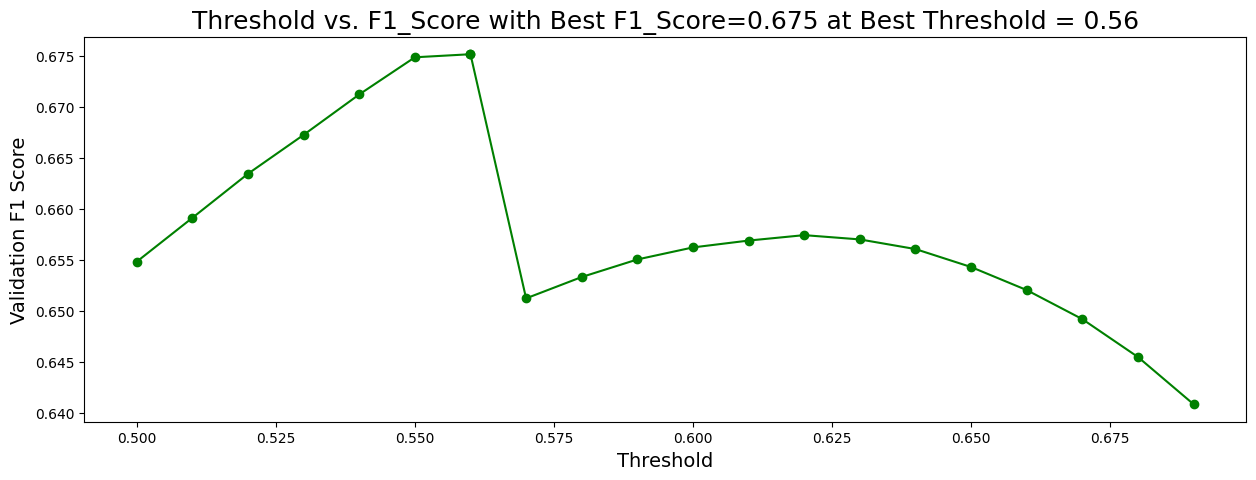

When using optimal threshold = 0.56...
Q0: F1 = 0.6249380082425678
Q1: F1 = 0.49459459459459454
Q2: F1 = 0.5043272746004934
Q3: F1 = 0.6384552304443806
Q4: F1 = 0.6385784189652883
Q5: F1 = 0.5746060916410229
Q6: F1 = 0.5745943659143921
Q7: F1 = 0.5363014259296588
Q8: F1 = 0.5907414769611408
Q9: F1 = 0.6103254222240602
Q10: F1 = 0.5753107004425232
Q11: F1 = 0.5754843132662343
Q12: F1 = 0.49352562083585705
Q13: F1 = 0.6082711026301759
Q14: F1 = 0.6342258159350642
Q15: F1 = 0.4240705687039807
Q16: F1 = 0.47065380963829345
Q17: F1 = 0.48734796893017995
==> Overall F1 = 0.6752108162555505
s


In [44]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

# Submission Jo Wilder

In [45]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [46]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [47]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    test = test.sort_values(by = 'index')
    sample_submission['q'] = sample_submission.session_id.apply(lambda x: x.split("_q")[1]).astype(int)
    sample_submission = sample_submission.sort_values(by = 'q')
    sample_submission.drop('q',axis=1,inplace=True)
    
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 1
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [48]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("==> Test MEAN: ",np.mean(sub1["correct"]))
sub1.head(18)

Shape:  (54, 2)
Shape:  (54, 2)
==> Test MEAN:  0.7037037


,session_id,correct
0,20090109393214576_q1,1.0
1,20090109393214576_q2,1.0
2,20090109393214576_q3,1.0
3,20090109393214576_q4,1.0
4,20090109393214576_q5,0.0
5,20090109393214576_q6,1.0
6,20090109393214576_q7,1.0
7,20090109393214576_q8,1.0
8,20090109393214576_q9,1.0
9,20090109393214576_q10,0.0
